In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True

session = InteractiveSession(config=config)

2023-01-26 19:17:51.460362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [3]:
from tensorflow.keras.utils import to_categorical

In [100]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

,Sales
Month,
0,86335
1,80239
2,85975
3,81726
4,80099
5,82571
6,85576
7,54411
8,52321


array([[<AxesSubplot: title={'center': 'Sales'}>]], dtype=object)

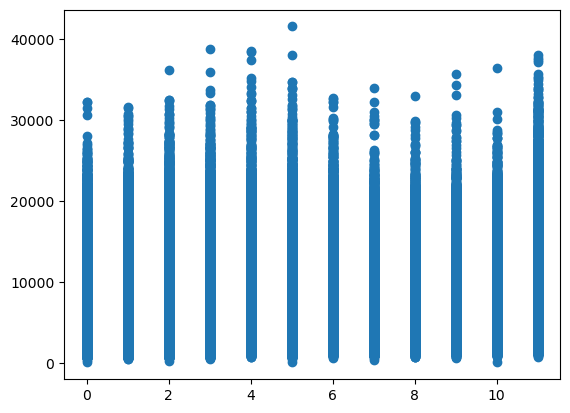

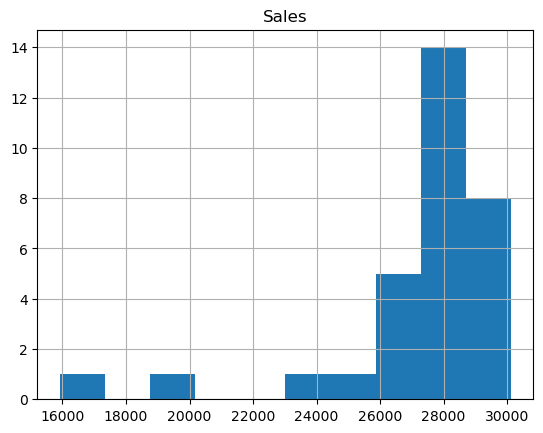

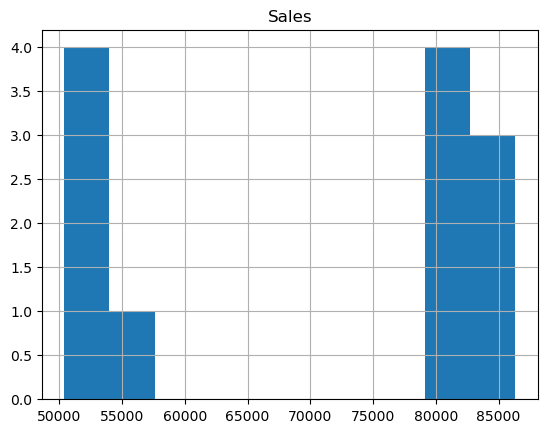

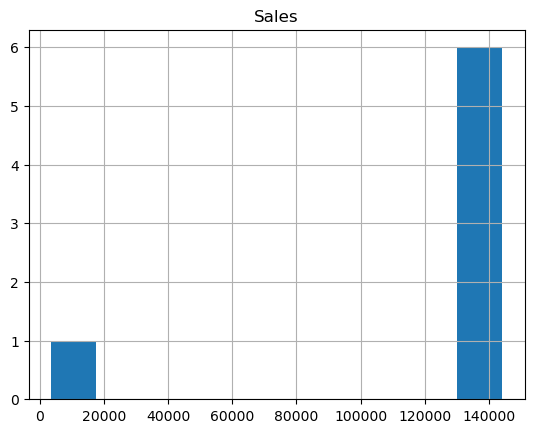

In [94]:
# df.loc[:,['StateHoliday','Sales']]
# import matplotlib.pyplot as plt
display(df.loc[:,['Month','Sales']].groupby('Month').count())
plt.scatter(df.Month,df.Sales)
df.loc[:,['Day','Sales']].groupby('Day').count().hist()
df.loc[:,['Month','Sales']].groupby('Month').count().hist()

In [101]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

cat_vars = ['Store', 'Month','StateHoliday','Assortment','State','Events']

In [102]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']
contin_vars = ['Max_TemperatureC','Mean_TemperatureC','BeforeStateHoliday_bool','CompetitionDistance','Precipitationmm']

In [103]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [104]:
uniques.T

,uniques
Store,1115
Month,12
StateHoliday,4
Assortment,3
State,12
Events,22


# Asignación de dimensión de embeddings

In [105]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 2, 'Year': 2, 'Month': 2,
'Day': 10, 'StateHoliday': 2, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 25, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_bool_fw': 1,
'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [106]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 50 1115 [   0    1    2 ... 1112 1113 1114]

Month 2 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

StateHoliday 2 4 [0 1 2 3]

Assortment 3 3 [0 1 2]

State 6 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Events 4 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]



# Definición de modelo

In [107]:
add_customers = False
log_output = False
output_activation = 'linear'

In [108]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

In [109]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [110]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [111]:
# Descomentar para ver resultados
# cat_vars_embed_outs
# cat_var_inputs
# cont_vars_inputs
# cont_vars_outs

In [112]:
first_hidden_units = 1000
second_hidden_units = 500
l2_lambda = 1e-3
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
x = Dense(first_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(merged)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = LeakyReLU()(x)
x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = LeakyReLU()(x)

output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)

In [113]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])

In [114]:
cat_var_inputs + cont_vars_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Store_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Month_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'StateHoliday_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Assortment_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'State_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Events_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Max_TemperatureC_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Mean_TemperatureC_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BeforeStateHoliday_bool_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'CompetitionDistance_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Precipitationmm_input')>]

In [115]:
# Descomentar para ver
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Month_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 StateHoliday_input (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 Assortment_input (InputLayer)  [(None, 1)]          0           []                         

In [116]:
model.save_weights('initial_weights.hdf5')

In [117]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


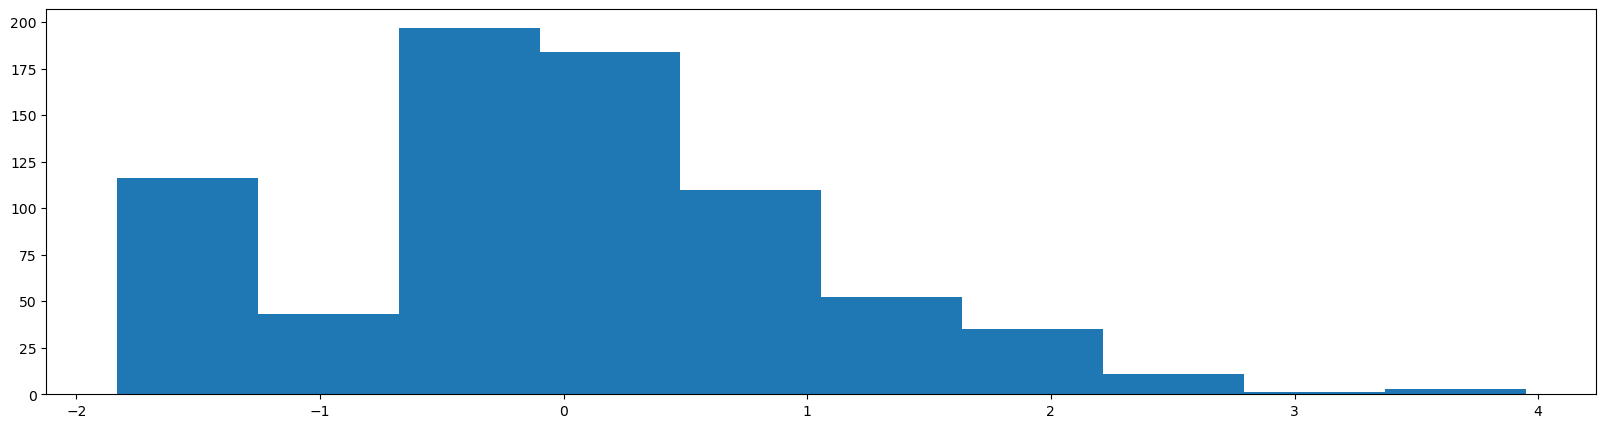

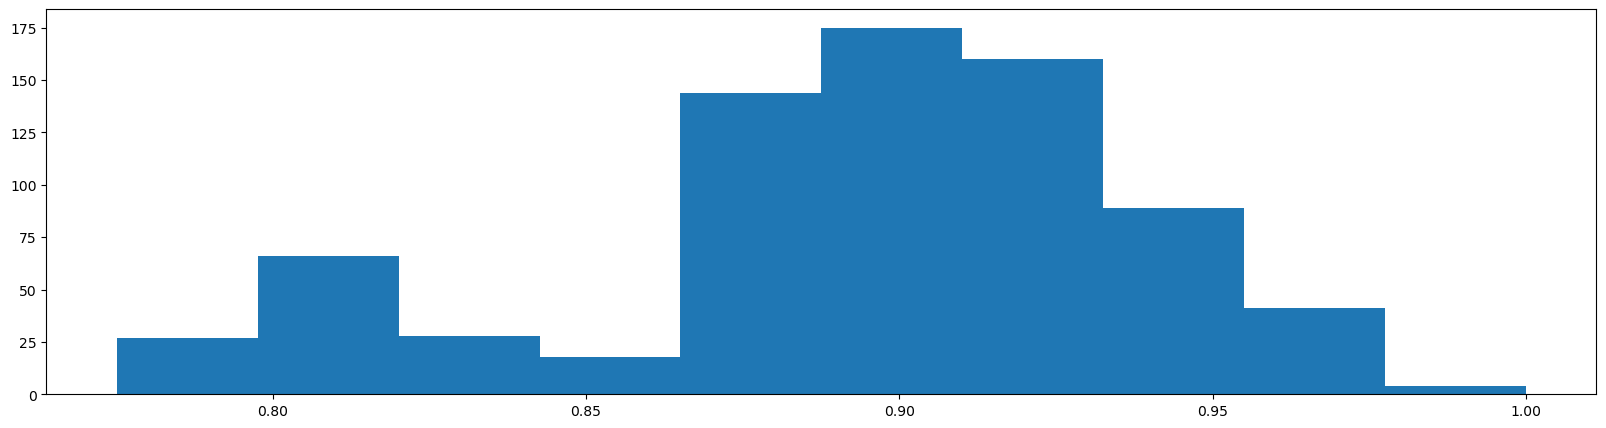

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
30192,34569,4,1,2015-06-30,6635,645,1,1.273237,0,-0.466372,...,-0.349784,1.072424,0,0,0,0,2,0,0,4
31307,35684,4,0,2015-06-29,7623,668,1,1.273237,0,-0.466372,...,-0.381854,1.072424,0,0,0,0,1,0,0,5
32454,37914,4,5,2015-06-27,1876,203,1,-0.785400,0,-0.466372,...,-0.445993,1.072424,8,-2,0,0,0,0,0,5
33569,39029,4,4,2015-06-26,3799,460,1,-0.785400,0,-0.466372,...,-0.478063,1.072424,7,-3,0,0,0,0,0,4
34684,40144,4,3,2015-06-25,3325,472,1,-0.785400,0,-0.466372,...,-0.510132,1.072424,6,-4,0,0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838765,1009409,4,0,2013-01-07,6978,717,1,1.273237,0,-0.466372,...,-0.991178,-1.392395,0,0,2,1,1,0,0,5
839890,1011639,4,5,2013-01-05,1590,202,1,-0.785400,0,-0.466372,...,-1.055317,-1.453255,0,-2,2,1,0,0,0,5
840997,1012754,4,4,2013-01-04,4456,533,1,-0.785400,0,-0.466372,...,-1.087387,-1.483685,0,-3,2,1,0,0,0,4
842105,1013869,4,3,2013-01-03,3465,491,1,-0.785400,0,-0.466372,...,-1.119456,-1.514115,0,-4,2,1,0,0,0,3


In [118]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,5))
store_id = 4
plt.hist((df_train[df_train['Store']==store_id]['Sales'].values - df_train[df_train['Store']==store_id]['Sales'].mean())/df_train[df_train['Store']==store_id]['Sales'].std())
plt.show()
plt.figure(figsize=(20,5))
plt.hist(np.log(df_train[df_train['Store']==store_id]['Sales'].values)/np.max(np.log(df_train[df_train['Store']==store_id]['Sales'].values)))
# plt.hist(df_train[df_train['Store'] == store_id]['Sales'],bins=50)
plt.show()
display(df_train[df_train['Store'] == store_id])

In [119]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [120]:
mean_by_store_train = df_train.loc[:,'Store'].apply(stores_mean.get).copy()
mean_by_store_val   = df_val.loc[:,'Store'].apply(stores_mean.get)

In [121]:
# df_test = pd.DataFrame({})
# df_test['mean_by_store'] = mean_by_store_train
# display(df_test.loc[:, 'mean_by_store'])

In [122]:
df_train.loc[:, 'mean_by_store'] = mean_by_store_train
df_val.loc[:, 'mean_by_store']   = mean_by_store_val

/var/folders/90/b05_bk0d2_z7wq_0d3_jqzd40000gn/T/ipykernel_95525/1626549377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'mean_by_store'] = mean_by_store_train
/var/folders/90/b05_bk0d2_z7wq_0d3_jqzd40000gn/T/ipykernel_95525/1626549377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'mean_by_store']   = mean_by_store_val


In [123]:
df_train.loc[:, 'Sales_store'] = df_train.loc[:,'Sales'] - df_train.loc[:,'mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val.loc[:,'Sales'] - df_val.loc[:,'mean_by_store']

/var/folders/90/b05_bk0d2_z7wq_0d3_jqzd40000gn/T/ipykernel_95525/1376271134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'Sales_store'] = df_train.loc[:,'Sales'] - df_train.loc[:,'mean_by_store']
/var/folders/90/b05_bk0d2_z7wq_0d3_jqzd40000gn/T/ipykernel_95525/1376271134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'Sales_store'] = df_val.loc[:,'Sales'] - df_val.loc[:,'mean_by_store']


In [124]:
from tensorflow.keras import backend as K

In [125]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [126]:
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())

In [127]:
get_metric(df_val, df_val['mean_by_store'])

0.3071746085338871

In [128]:
# all_vars
# np.hsplit(df_train[all_vars].values, len(all_vars))
# np.hsplit(df_val[all_vars].values, len(all_vars))
# np.hsplit(df_test[all_vars].values, len(all_vars))

In [129]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [130]:
y_out_columns = []
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    # y_out_columns = ['Sales_store']
    y_out_columns = ['Sales']
display(y_out_columns)

['Sales']

In [131]:
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
#     y_mean = df_train[y_out_columns].mean().values
#     y_std = df_train[y_out_columns].std().values
#     y_train = (df_train[y_out_columns].values - y_mean)/y_std
#     y_val = (df_val[y_out_columns].values - y_mean)/y_std
    y_max = df_train[y_out_columns].max().values
    y_train = df_train[y_out_columns].values/y_max
    y_val = df_val[y_out_columns].values/y_max
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

In [132]:
lr = 0.001
model.compile(optimizer=Adam(learning_rate=lr), metrics=['mse', rmspe], loss='mse')

In [133]:
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
epochs = 64
batch_size = 128
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], verbose=1)

Epoch 1/64
6359/6361 [============================>.] - ETA: 0s - loss: 0.0021 - mse: 0.0021 - rmspe: 0.3409
Epoch 1: val_loss did not improve from 0.00171
6361/6361 [==============================] - 86s 13ms/step - loss: 0.0021 - mse: 0.0021 - rmspe: 0.3409 - val_loss: 0.0019 - val_mse: 0.0019 - val_rmspe: 0.2815
Epoch 2/64
6358/6361 [============================>.] - ETA: 0s - loss: 0.0021 - mse: 0.0021 - rmspe: 0.3407
Epoch 2: val_loss did not improve from 0.00171
6361/6361 [==============================] - 86s 14ms/step - loss: 0.0021 - mse: 0.0021 - rmspe: 0.3407 - val_loss: 0.0018 - val_mse: 0.0017 - val_rmspe: 0.2732
Epoch 3/64
6358/6361 [============================>.] - ETA: 0s - loss: 0.0021 - mse: 0.0021 - rmspe: 0.3408
Epoch 3: val_loss did not improve from 0.00171
6361/6361 [==============================] - 328s 52ms/step - loss: 0.0021 - mse: 0.0021 - rmspe: 0.3408 - val_loss: 0.0018 - val_mse: 0.0018 - val_rmspe: 0.2631
Epoch 4/64
6358/6361 [==========================

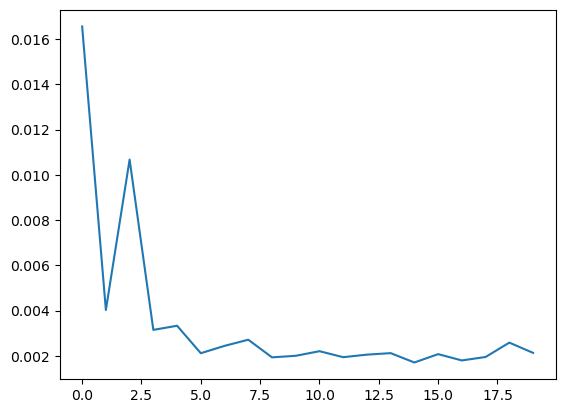

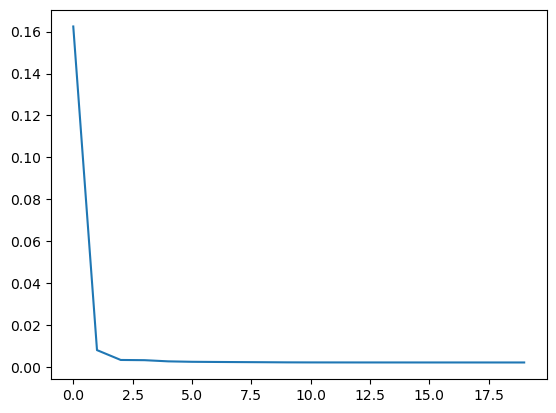

In [135]:
plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_Customers_mse'])
# plt.plot(history.history['val_Sales_mse'])
plt.show()
plt.plot(history.history['loss'])
# plt.plot(history.history['Customers_mse'])
# plt.plot(history.history['Sales_mse'])

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [45]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 3s 3ms/step - loss: 8.8697e-04 - mse: 8.3922e-04 - rmspe: 0.1764


[0.0008869694429449737, 0.0008392218733206391, 0.1764046549797058]

In [46]:
model.load_weights('bestmodel.hdf5')
model.evaluate(X_val, y_val)

944/944 [==============================] - 3s 4ms/step - loss: 8.3316e-04 - mse: 7.8532e-04 - rmspe: 0.1787


[0.0008331572753377259, 0.0007853202405385673, 0.17867758870124817]

In [151]:
# model.load_weights('bestmodel.hdf5')
# model.evaluate(X_val, y_val)
# 30188/30188 [==============================] - 5s 172us/step
# [0.12197033089921382,
#  0.07211007360268763,
#  0.037183713050426136,
#  0.07211007360268763,
#  0.037183713050426136]

# [0.12932546436786652,
#  0.07751645147800446,
#  0.039259567856788635,
#  0.07751645147800446,
#  0.039259567856788635]

In [47]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
        y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
    else:
#         y_pred = model.predict(X_val, verbose=1)[:,0]*y_std + y_mean
#         y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max
y_pred_test[df_test['Open'] == 0] = 0

1284/1284 [==============================] - 4s 3ms/step


In [48]:
np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

0.2096286018158675

In [49]:
y_pred_test[:10]

array([4430.46043247, 6314.99147071, 7819.00772378, 4892.19793149,
       6107.70970567, 4868.14425657, 7292.70224595, 6946.11856565,
       4553.7716598 , 4924.16166134])

# Baseline

In [51]:
import pandas as pd
sample_csv = pd.read_csv('rossmann/sample_submission.csv')

In [52]:
stores_mean = {}
for store, g_df in df.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [53]:
df_test['Sales'] = df_test['Store'].apply(stores_mean.get)
df_test.loc[df_test['Open'] == 0, 'Sales'] = 0

In [54]:
df_test[['Store', 'Sales']].head(10)

,Store,Sales
0,0,4759.096031
1,2,6942.568678
2,6,8817.050891
3,7,5539.358418
4,8,6562.337612
5,9,5568.420918
6,10,8030.977041
7,11,7589.598214
8,12,5034.747182
9,13,5508.567394


In [55]:
df_test[df_test['Open'] == 0][['Store', 'Sales']].head()

,Store,Sales
543,702,0.0
676,878,0.0
840,1096,0.0
1399,702,0.0
1532,878,0.0


In [56]:
sample_csv['Sales'] = df_test['Sales']

In [57]:
sample_csv.to_csv(f'submision_baseline.csv', index=False)

In [58]:
sample_csv.head()

,Id,Sales
0,1,4759.096031
1,2,6942.568678
2,3,8817.050891
3,4,5539.358418
4,5,6562.337612


# Sumbit a la competición

In [60]:

sample_csv = pd.read_csv('rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_{add_customers}-{log_output}-{output_activation}-{l2_lambda}-{first_hidden_units}-{epochs}-{batch_size}-{lr}.csv', index=False)


# Analisis de embedings

In [98]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

(7, 2)


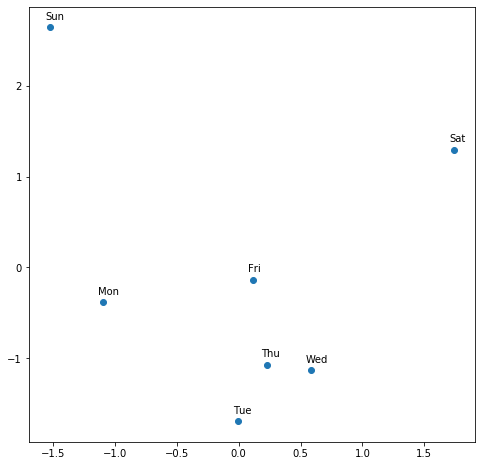

In [99]:
model.load_weights('bestmodel.hdf5')
plot_embed('DayOfWeek_Embed', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

(12, 2)


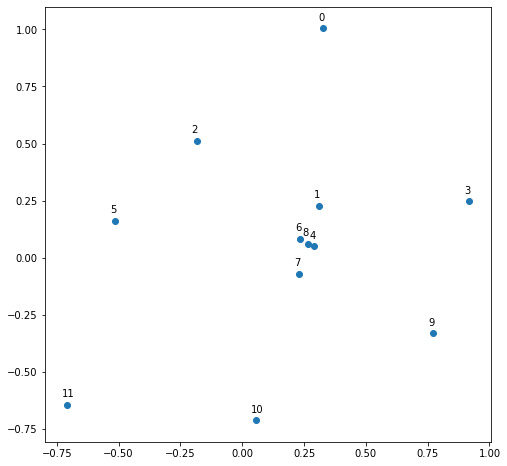

In [103]:
plot_embed('Month_Embed', list(range(12)))

In [43]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [51]:
day_of_week_embedding.shape

(7, 2)

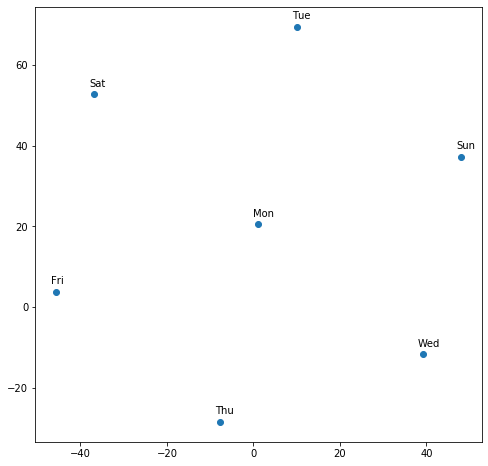

In [58]:
tsne = TSNE(n_components=2, random_state=1, learning_rate=10, n_iter=10000)
Y = tsne.fit_transform(day_of_week_embedding)
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

In [93]:
cat_vars

['Store',
 'DayOfWeek',
 'Year',
 'Month',
 'Day',
 'StateHoliday',
 'CompetitionMonthsOpen',
 'Promo2Weeks',
 'StoreType',
 'Assortment',
 'PromoInterval',
 'CompetitionOpenSinceYear',
 'Promo2SinceYear',
 'State',
 'Week',
 'Events',
 'Promo_fw',
 'Promo_bw',
 'StateHoliday_fw',
 'StateHoliday_bw',
 'SchoolHoliday_fw',
 'SchoolHoliday_bw']

## Store embeddings

In [94]:
submodel = Model(cat_var_inputs + cont_vars_inputs, merged)

In [95]:
submodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Year_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Month_input (InputLayer)        [(None, 1)]          0                                            
____________________________________________________________________________________________

In [52]:
submodel.save('embeddings_model.hdf5')